In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline
sns.set_style('white')

In [2]:
df_raw = pd.read_csv('georgia_crime.csv')
df_raw.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Unnamed: 13
0,Abbeville,"2,888",3,0.0,NaN,0.0,2,1,22,3,16,3,0.0,NaN
1,Adairsville,"4,686",13,0.0,NaN,0.0,1,12,52,15,31,6,0.0,NaN
2,Adel,"5,240",18,0.0,NaN,5.0,5,8,189,64,121,4,0.0,NaN
3,Adrian,656,0,0.0,NaN,0.0,0,0,2,0,2,0,0.0,NaN
4,Alapaha,646,5,0.0,NaN,0.0,1,4,6,0,6,0,0.0,NaN


In [3]:
#rename columns in a more friendly manner
df_raw.rename(columns={'City': 'city',
                         'Population': 'population',
                         'Violent\ncrime': 'violent_crime',
                         'Murder and\nnonnegligent\nmanslaughter': 'murder',
                         'Rape\n(revised\ndefinition)1': 'rape_legacy',
                         'Rape\n(legacy\ndefinition)2': 'rape',
                         'Robbery': 'robbery',
                         'Aggravated\nassault': 'aggravated_assault',
                         'Property\ncrime': 'property_crime',
                         'Burglary': 'burglary',
                         'Larceny-\ntheft': 'larceny_theft',
                         'Motor\nvehicle\ntheft': 'vehicle_theft',
                         'Arson3': 'arson',
                         'Unnamed: 13': 'unnamed'}, inplace=True)
#drop the rape legacy and unnamed columns as they have no values
#drop the city column
df_georgia = df_raw.drop(['rape_legacy', 'unnamed', 'city'], 1)
#drop the last three lines as they are footnotes
df_georgia = df_georgia.drop(df_raw.index[-3:])

In [4]:
#remove all commas from the data set, and turn objects into ints
for col in df_georgia.select_dtypes(object):
    df_georgia[col] = df_georgia[col].str.replace(',', '')

#fill arson NaN values with zero and convert to ints
df_georgia = df_georgia.fillna(0)
df_georgia = df_georgia.astype(int)

In [5]:
df_texas = pd.read_csv('texas_crime.csv')

#rename columns in a more friendly manner
df_texas.rename(columns={'City': 'city',
                         'Population': 'population',
                         'Violent\ncrime': 'violent_crime',
                         'Murder and\nnonnegligent\nmanslaughter': 'murder',
                         'Rape\n(revised\ndefinition)1': 'rape_legacy',
                         'Rape\n(legacy\ndefinition)2': 'rape',
                         'Robbery': 'robbery',
                         'Aggravated\nassault': 'aggravated_assault',
                         'Property\ncrime': 'property_crime',
                         'Burglary': 'burglary',
                         'Larceny-\ntheft': 'larceny_theft',
                         'Motor\nvehicle\ntheft': 'vehicle_theft',
                         'Arson3': 'arson',
                         'Unnamed: 13': 'unnamed'}, inplace=True)

#drop the rape legacy and unnamed columns as they have no values
#drop the city column
df_texas = df_texas.drop(['rape_legacy', 'unnamed', 'city'], 1)

#remove all commas from the data set, and turn objects into ints
for col in df_texas.select_dtypes(object):
    df_texas[col] = df_texas[col].str.replace(',', '')

#fill arson NaN values with zero and convert to ints
df_texas = df_texas.fillna(0)
df_texas = df_texas.astype(float)

In [6]:
df = df_georgia.append(df_texas, ignore_index=True)

#drop the last three lines as they are footnotes
df = df.drop(df.index[-3:])

#fill NaN values with zero and convert to ints
df = df.fillna(0)
df = df.astype(float)

In [7]:
df['violent_crime'].sum() / df['property_crime'].sum()

0.12135884401934409

In [8]:
#compare if there are more violent crimes than the average
df['crime_compare'] = df['violent_crime'] / df['property_crime']
df['crime_bool'] = np.where(df['crime_compare'] > 0.121, 1, 0)
#set if a murder takes place to 1, if not zero
df['murder_bool'] = np.where(df['murder'] > 0, 1, 0)
#drop any index with a NaN for population
df['population'] = df['population'].dropna()
#take the log of the population
df['population_log'] = np.log(df['population'])
#replace NaN with 1 for crime compare values 
df['crime_compare'] = df['crime_compare'].fillna(1)
#remove any inf, -inf, or remaining NaN
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

In [9]:
df.groupby('murder_bool').size()

murder_bool
0    642
1    215
dtype: int64

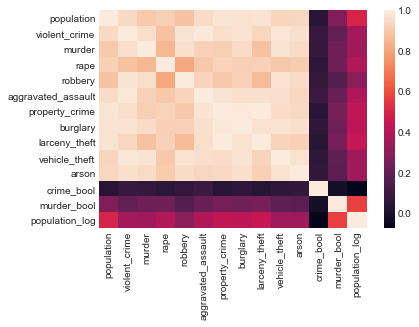

In [10]:
sns.heatmap(df.corr())
plt.show()

In [11]:
#drop violent crime and murder as they are already what we are looking to predict
X = df.drop(['violent_crime', 'murder', 'murder_bool'], 1)
y = df.murder_bool

In [12]:
#build a random forest classifier to help determine most valuable features
rfc = ensemble.RandomForestClassifier(n_estimators=500)
rfc.fit(X, y)
print(sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), X.columns), 
             reverse=True))

[(0.1528, 'property_crime'), (0.1407, 'larceny_theft'), (0.1286, 'robbery'), (0.12, 'burglary'), (0.1144, 'population'), (0.1066, 'population_log'), (0.0826, 'aggravated_assault'), (0.0804, 'vehicle_theft'), (0.0381, 'rape'), (0.0265, 'arson'), (0.0094, 'crime_bool')]


In [13]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
#use standard scaler for use in PCA due to high multicollinearity
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
#two comp were selected for PCA
pca = PCA(2)
X_trainpca = pca.fit_transform(X_train_scaled)
X_testpca = pca.transform(X_test_scaled)


print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    pca.explained_variance_ratio_,
    '\n',
    np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.79648573 0.09431235] 
 [79.65 89.08]


In [16]:
#logistic regression
logr = linear_model.LogisticRegression()
logr.fit(X_trainpca, y_train)
print('R2 Train Score: ', logr.score(X_trainpca, y_train))

print('R2 Test Score: ', logr.score(X_testpca, y_test))

R2 Train Score:  0.8321167883211679
R2 Test Score:  0.8488372093023255


In [17]:
#lasso regression
lass = linear_model.Lasso(alpha=.1, max_iter=100000)
lass.fit(X_train, y_train)
print(lass.score(X_train, y_train))

print(lass.score(X_test, y_test))

0.29543239532914867
0.27105829060848863


In [18]:
#ridge regression
ridges = linear_model.Ridge()
ridges.fit(X_train, y_train)
print(ridges.score(X_train, y_train))

print(ridges.score(X_test, y_test))

0.34102668804650993
0.3285127565435957
